In [6]:
import keras
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# The purpose of this jupyter notebook is to have deep understand at the label generate methods, how we generate the labels from anchors and groundtruth

In [7]:
data = pd.read_csv('voc.csv')
data = data.drop('Unnamed: 0', 1)
data['File_Path'] = './VOCdevkit2007/VOC2007/JPEGImages/' + data['Frame']
#data = data[(data['label'] == 0)].reset_index()
print(data.head())

        Frame   xmin   xmax   ymin   ymax  label  type  \
0  003815.jpg  188.0  433.0  108.0  213.0    0.0  test   
1  003815.jpg  231.0  259.0    1.0   54.0    1.0  test   
2  003815.jpg  186.0  219.0    1.0   54.0    1.0  test   
3  003815.jpg  242.0  274.0   11.0   95.0    1.0  test   
4  003815.jpg  288.0  333.0  125.0  149.0    1.0  test   

                                       File_Path  
0  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
2  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
3  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
4  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  


In [10]:
def csv2bbox(bbox):
    gta = np.zeros((len(bb_boxes), 4))
    #print(gta.shape)
    #bbox groundtruth before bbox_encode
    for i in range(len(bb_boxes)):
        gta[i, 0] = int(bb_boxes.iloc[i]['xmin'])
        gta[i, 1] = int(bb_boxes.iloc[i]['ymin'])
        gta[i, 2] = int(bb_boxes.iloc[i]['xmax'])
        gta[i, 3] = int(bb_boxes.iloc[i]['ymax'])
    return gta

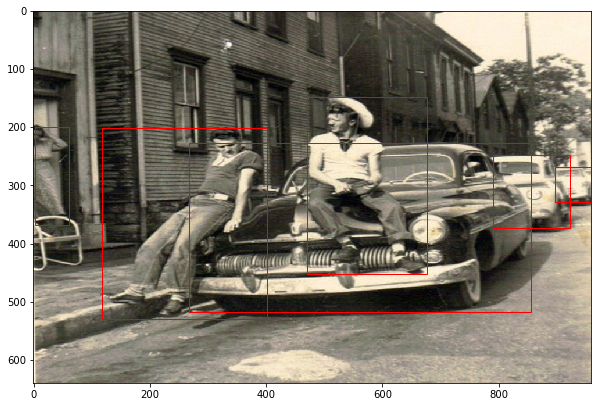

In [15]:
#load img and bbox
import batch_generate
i_line = np.random.randint(len(data))
name_str, img, bb_boxes = batch_generate.get_img_by_name(data, i_line, size = (960, 640))
gta = csv2bbox(bb_boxes)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
for i in range(len(gta)):
    currentAxis.add_patch(plt.Rectangle((gta[i,0], gta[i,1]), gta[i,2]-gta[i,0], gta[i,3]-gta[i,1], fill=False, edgecolor= 'r', linewidth=1))

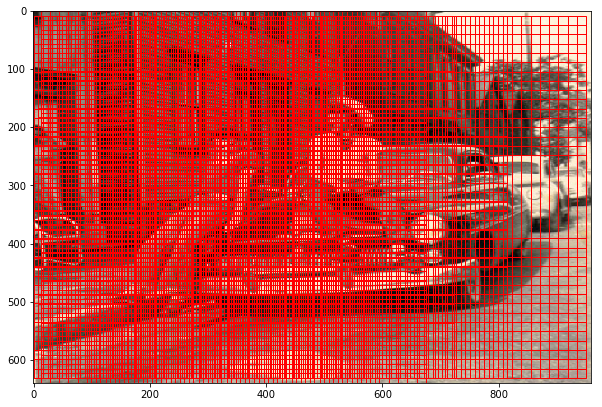

In [18]:
#applied anchors here
(output_width, output_height) = (60, 40)
num_anchors = 9
anchor_box = batch_generate._generate_all_bbox(output_width, output_height)
total_anchors = anchor_box.shape[0]
#print('the shape of anchor_box', np.asarray(anchor_box).shape)
#print('the total number os anchors',total_anchors)

#Only inside anchors are valid
_allowed_border = 0
im_info = img.shape[:2]
inds_inside = np.where(
(anchor_box[:, 0] >= -_allowed_border) &
(anchor_box[:, 1] >= -_allowed_border) &
(anchor_box[:, 2] < im_info[1] + _allowed_border) &  # width
(anchor_box[:, 3] < im_info[0] + _allowed_border)    # height
)[0]
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = anchor_box[inds_inside]
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [33]:
import utils
y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
y_rpn_regr = np.zeros((output_height * output_width * num_anchors , 4))
y_rpn_regr[inds_inside] = anchor_box[inds_inside, :]
overlaps = utils.bbox_overlaps(np.ascontiguousarray(y_rpn_regr, dtype=np.float),np.ascontiguousarray(gta, dtype=np.float))
argmax_overlaps = overlaps.argmax(axis=1)
max_overlaps = np.zeros((output_height * output_width * num_anchors))
max_overlaps[inds_inside] = overlaps[np.arange(len(inds_inside)), argmax_overlaps[inds_inside]]
gt_argmax_overlaps = overlaps.argmax(axis=0)
gt_max_overlaps = overlaps[gt_argmax_overlaps,np.arange(overlaps.shape[1])]
gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]
print(gt_argmax_overlaps)
print(gt_max_overlaps)

[ 4637  4646  4646  4997  5006  5006  5357  5366  5366  5717  5726  5726
  6077  6086  6086  6153  6437  6442  6446  6446  6451  6797  6802  6806
  6806  6811  7157  7162  7166  7166  7171  7481  7490  7499  7508  7517
  7517  7526  7526  7526  7699  7708  7841  7850  7859  7868  7877  7877
  7886  7886  7886  8059  8068  8201  8210  8219  8228  8237  8237  8246
  8246  8246  8419  8428  8561  8570  8579  8588  8597  8597  8606  8606
  8606  8779  8788  8921  8930  8939  8948  8957  8957  8966  8966  8966
  9281  9290  9299  9308  9317  9317  9326  9326  9326  9677  9686  9686
 10037 10046 10046]
[ 0.49019608  0.69893884  0.75388449  0.01204173  0.05931556  0.60957314]


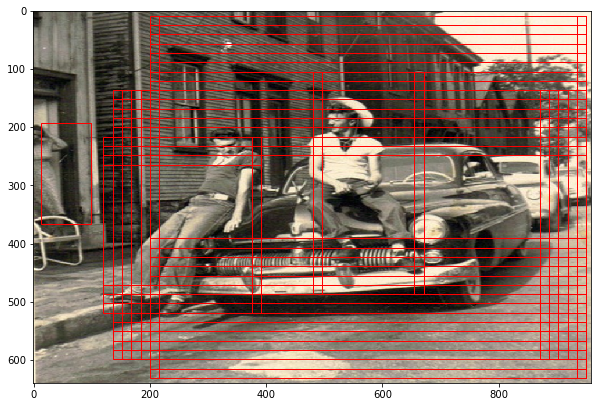

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = y_rpn_regr[gt_argmax_overlaps]
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [39]:
y_rpn_overlap = y_rpn_overlap.reshape(output_height * output_width * num_anchors)
y_is_box_valid = y_is_box_valid.reshape(output_height * output_width * num_anchors)
#negative
#print('shape of y_rpn_overlap', y_rpn_overlap.shape)
#print('shape of y_is_box_valid',y_is_box_valid.shape)
y_rpn_overlap[max_overlaps < neg_min_overlaps] = 0
y_is_box_valid[inds_inside] = 1
#y_is_box_valid[max_overlaps < neg_min_overlaps] = 1#not good way to set all box as valid, because we also have outside box here

#neutral
#np.logical_and
y_rpn_overlap[np.logical_and(neg_min_overlaps < max_overlaps, max_overlaps < pos_max_overlaps)] = 0
y_is_box_valid[np.logical_and(neg_min_overlaps < max_overlaps, max_overlaps < pos_max_overlaps)] = 0

#positive
y_rpn_overlap[gt_argmax_overlaps] = 1
y_is_box_valid[gt_argmax_overlaps] = 1
y_rpn_overlap[max_overlaps >= pos_max_overlaps] = 1
y_is_box_valid[max_overlaps >= pos_max_overlaps] = 1

#y_rpn_overlap[neg_min_overlaps < max_overlaps and max_overlaps < pos_max_overlaps] = 0
#y_is_box_valid[neg_min_overlaps < max_overlaps and max_overlaps < pos_max_overlaps] = 0

# subsample positive labels if we have too many
num_fg = int(fraction * batchsize)
#print('balanced fg',num_fg)
disable_inds = []
fg_inds = np.where(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 1))[0]
#print('fg number',len(fg_inds))
if len(fg_inds) > num_fg:
    disable_inds = npr.choice(fg_inds, size=(len(fg_inds) - num_fg), replace=False)
    #labels[disable_inds] = -1
    y_is_box_valid[disable_inds] = 0
    y_rpn_overlap[disable_inds] = 0

# subsample negative labels if we have too many
num_bg = batchsize - np.sum(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 1))
bg_inds = np.where(np.logical_and(y_rpn_overlap == 0, y_is_box_valid == 1))[0]
#print('bg number',len(bg_inds))
if len(bg_inds) > num_bg:
    disable_inds = npr.choice(bg_inds, size=(len(bg_inds) - num_bg), replace=False)
    #labels[disable_inds] = -1
    y_is_box_valid[disable_inds] = 0
    y_rpn_overlap[disable_inds] = 0
#print ("was %s inds, disabling %s, now %s %sinds" % (len(bg_inds), len(disable_inds), np.sum(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 0))))
print('negative samples',np.where(np.logical_and(y_rpn_overlap == 0, y_is_box_valid == 1))[0])
print('postive samples',np.where(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 1))[0])
print('number of postive samples',len(np.where(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 1))[0]))
print('number of negative samples',len(np.where(np.logical_and(y_rpn_overlap == 0, y_is_box_valid == 1))[0]))

negative samples [ 1650  2133  2253  2280  2286  2310  2325  2359  2476  2664  2805  2871
  3028  3169  3390  3412  3480  3514  3531  3561  3583  3676  3780  3871
  3933  4054  4240  4405  4416  4513  4624  4632  4641  4777  4801  4900
  4924  4970  5157  5206  5251  5274  5286  5335  5371  5398  5506  5508
  5521  5526  5562  5563  5604  5670  5736  5746  5838  5886  5910  5917
  5953  6172  6207  6237  6249  6255  6325  6327  6356  6360  6403  6409
  6591  6615  6621  6625  6725  6738  6771  6813  6829  6900  6916  6958
  6975  6976  6979  7030  7035  7058  7059  7076  7079  7098  7102  7105
  7111  7125  7252  7300  7447  7461  7470  7503  7547  7611  7689  7692
  7710  7762  7792  7878  7882  8229  8367  8443  8473  8478  8742  8743
  8754  8784  8830  8869  8874  8926  8944  8947  9136  9141  9245  9294
  9312  9319  9328  9355  9496  9565  9645  9711  9790  9828  9888  9955
  9973  9981 10045 10182 10210 10258 10266 10539 10549 10590 10669 10686
 10842 10876 10980 11049 11134 112

[ 4637  4646  4997  5006  5357  5366  5717  5726  6077  6086  6153  6437
  6442  6446  6451  6797  6802  6806  6811  7157  7162  7166  7171  7481
  7490  7499  7508  7517  7526  7699  7708  7841  7850  7859  7868  7877
  7886  8059  8068  8201  8210  8219  8228  8237  8246  8419  8428  8561
  8570  8579  8588  8597  8606  8779  8788  8921  8930  8939  8948  8957
  8966  9281  9290  9299  9308  9317  9326  9677  9686 10037 10046]


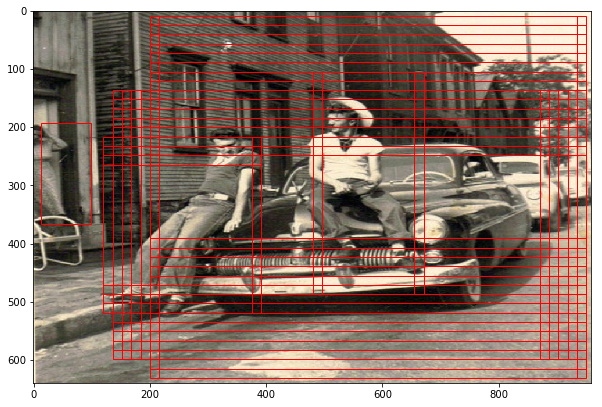

In [40]:
#postive samples
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
postive = np.where(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 1))[0]
print(np.where(np.logical_and(y_rpn_overlap == 1, y_is_box_valid == 1))[0])
box = y_rpn_regr[postive,:]
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

[ 1650  2133  2253  2280  2286  2310  2325  2359  2476  2664  2805  2871
  3028  3169  3390  3412  3480  3514  3531  3561  3583  3676  3780  3871
  3933  4054  4240  4405  4416  4513  4624  4632  4641  4777  4801  4900
  4924  4970  5157  5206  5251  5274  5286  5335  5371  5398  5506  5508
  5521  5526  5562  5563  5604  5670  5736  5746  5838  5886  5910  5917
  5953  6172  6207  6237  6249  6255  6325  6327  6356  6360  6403  6409
  6591  6615  6621  6625  6725  6738  6771  6813  6829  6900  6916  6958
  6975  6976  6979  7030  7035  7058  7059  7076  7079  7098  7102  7105
  7111  7125  7252  7300  7447  7461  7470  7503  7547  7611  7689  7692
  7710  7762  7792  7878  7882  8229  8367  8443  8473  8478  8742  8743
  8754  8784  8830  8869  8874  8926  8944  8947  9136  9141  9245  9294
  9312  9319  9328  9355  9496  9565  9645  9711  9790  9828  9888  9955
  9973  9981 10045 10182 10210 10258 10266 10539 10549 10590 10669 10686
 10842 10876 10980 11049 11134 11280 11325 11332 11

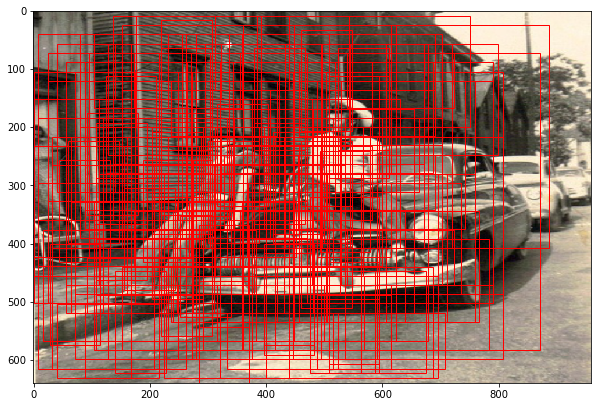

In [41]:
#negative samples
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
negative = np.where(np.logical_and(y_rpn_overlap == 0, y_is_box_valid == 1))[0]
print(np.where(np.logical_and(y_rpn_overlap == 0, y_is_box_valid == 1))[0])
box = y_rpn_regr[negative,:]
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [42]:
#bbox transfer for all valid postive samples
rpn_regr = np.zeros((output_height * output_width * num_anchors , 4))
y_rpn_regr[postive,:] = utils._compute_targets(y_rpn_regr[postive,:], gta[argmax_overlaps[postive], :])
print(len(y_rpn_regr[postive,:]))

71


In [49]:
import bbox_decode
anchor_box = batch_generate._generate_all_bbox(output_width, output_height)

proposals = bbox_decode.bbox_transform_inv_cpu(anchor_box[postive], y_rpn_regr[postive,:])
#proposals = bbox_decode.bbox_transform_inv_cpu(anchor_box, y_rpn_regr)
print(proposals.shape)

(71, 4)


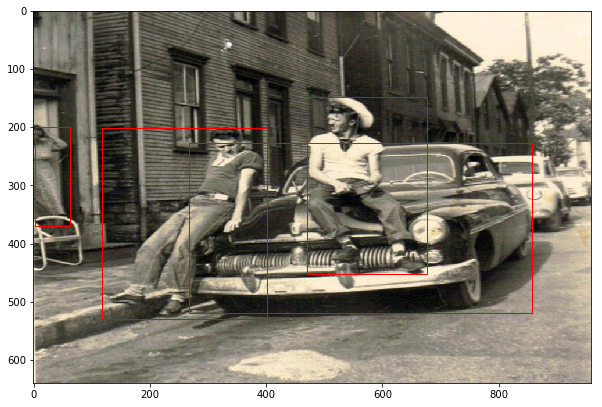

In [50]:
#bbox transfer
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = proposals
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))